# HW2: Single-View Geometry

### Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import warnings; warnings.simplefilter('ignore')
import matplotlib.lines as mlines

from PIL import Image

## Problem 1: line-line intersection

### 1.1 Proof

### 1.2 Proof

### 1.3

In this section we will build up some tools we will use later. 

In [2]:
# Provided plotting functions

def draw_line(x,y,xlims=[0, 15],c='b--',linewidth=2):
    xrange = np.arange(xlims[0],xlims[1],0.1)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y)[0]
    plt.plot(xrange, k*xrange + b, c, linewidth=linewidth)
    
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

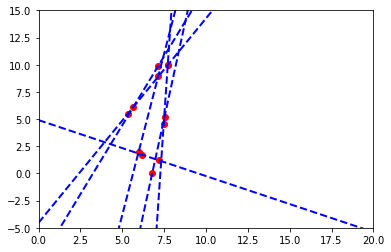

In [3]:
n = 6
P0 = np.stack((np.array([5, 5]) + 3*np.random.random(size=2) for i in range(n)))
a = np.linspace(0, 2*np.pi,n) + np.random.random(size=n)*np.pi/5.0
P1 = np.array([5 + 5*np.sin(a),5 + 5*np.cos(a)]).T

x = np.stack((P0[:,0], P0[:,1]))
y = np.stack((P1[:,0], P1[:,1]))

xlims = [0,20]
plt.xlim(xlims)
plt.ylim([-5,15])
plt.plot(x, y, 'ro')

for i in range(n):
    draw_line(P0[i,:], P1[i,:], xlims=xlims)


Let $A = I - nn^T$
$$
\frac{\partial D}{\partial p} = -(A + A^T) (a - p) \\
\sum_{i=1}^n (I - n_i n_i^T + (I - n_i n_i^T)^T) p = \sum_{i=1}^n (I - n_i n_i^T + (I - n_i n_i^T)^T) a_i
$$

In [4]:
def find_intersection(x, y):
    A = np.zeros((2, 2))
    b = 0
    for i in range(x.shape[1]):
        point0 = np.vstack([x[0, i], y[0, i]])
        point1 = np.vstack([x[1, i], y[1, i]])
        vec_n = point0 - point1
        vec_n /= np.linalg.norm(vec_n) # normalize
        vec_a = point0
        mat = np.eye(2) - vec_n @ vec_n.T
        coef = mat + mat.T # A + A.T
        A += coef
        b += coef @ vec_a
    p_optim = np.linalg.lstsq(A, b)[0]
    return p_optim

In [5]:
p_optim = find_intersection(x, y)
p_optim

array([[5.87424722],
       [3.06853552]])

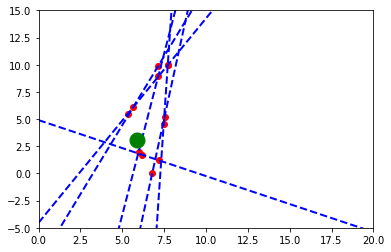

In [6]:
xlims = [0,20]
plt.xlim(xlims)
plt.ylim([-5,15])
plt.plot(x, y, 'ro')

for i in range(n):
    draw_line(P0[i,:], P1[i,:], xlims=xlims)
    
# draw p_optim
plt.plot(p_optim[0], p_optim[1], 'go', markersize=15)

# Problem 2: Vanishing Point Estimation

In [7]:
im = np.asarray(Image.open('data/stadium.png'))
plt.figure(figsize=(20, 40))

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

Use the provided pixel locations to solve for the vanishing points, then solve for the horizon line from the vanishing points.

In [8]:
# Load in points from points.txt
points = np.genfromtxt("data/points.txt", delimiter=',')

points_dict = []
with open('data/points_dict.txt','r') as inf:
    for line in inf:
        points_dict.append(eval(line))  
        
points_dict = points_dict[0]

In [9]:
points_start = np.empty((3, 3, 2)) # line, group, x and y coords
points_end = np.empty((3, 3, 2))
for key in points_dict:
    if key.startswith('s'):
        pointer_to_array = points_start
    else:
        pointer_to_array = points_end
    line_no = int(key[1]) - 1
    group_no = int(key[2]) - 1
    pointer_to_array[line_no, group_no] = points_dict[key]

In [10]:
points_x = np.stack([points_start[:, :, 0], points_end[:, :, 0]])
points_y = np.stack([points_start[:, :, 1], points_end[:, :, 1]])

### Visualize the lines

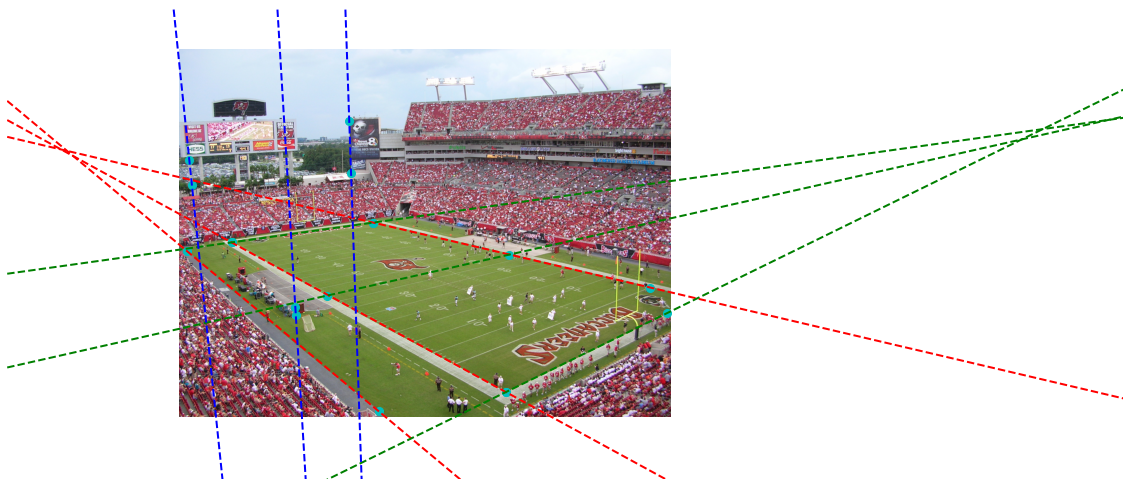

In [11]:
plt.figure(figsize=(20, 40))
plt.imshow(im)
plt.ylim([2000, -200])
xlims = [-800, 4400]
plt.xlim(xlims)
plt.axis('off')

plt.plot(points_x.flatten(), points_y.flatten(), 'co', markersize=8)

for group, color in zip(range(3), ['r', 'g', 'b']):
    c = color + '--'
    for i in range(3):
        draw_line(points_x[:, group, i], 
                  points_y[:, group, i], c=c, xlims=xlims)

### Find vanishing points

In [12]:
vanishing_points = np.empty((3, 2))
for group in range(3): # three groups
    p = find_intersection(points_x[:, group, :], points_y[:, group, :])
    vanishing_points[group] = p.squeeze()

In [13]:
vanishing_points

array([[ -523.83136567,   473.55581746],
       [ 4005.11004099,   385.09234096],
       [ 1163.06727547, 11290.40528595]])

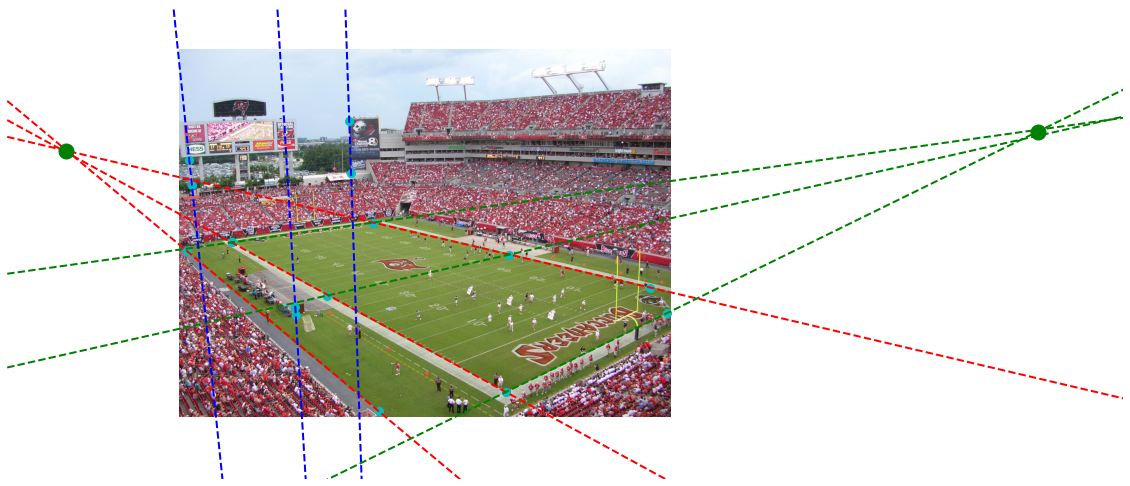

In [14]:
plt.figure(figsize=(20, 40))
plt.imshow(im)
plt.ylim([2000, -200])
xlims = [-800, 4400]
plt.xlim(xlims)
plt.axis('off')

plt.plot(points_x.flatten(), points_y.flatten(), 'co', markersize=8)

for group, color in zip(range(3), ['r', 'g', 'b']):
    c = color + '--'
    for i in range(3):
        draw_line(points_x[:, group, i], 
                  points_y[:, group, i], c=c, xlims=xlims)
        
# draw vanishing points in big green dots
vp_x = vanishing_points
plt.plot(vanishing_points[:, 0], vanishing_points[:, 1], 'go', markersize=15)

### Vertical vanishing point

The vertical vanishing point is much further away from the image plane because mathematically it is at infinity.

### Horizion

I connected a straight line between the two intersection points (visible in the plot) I identified in the previous step.

Yes, it corresponds to my intuitive notion of a horizon, in the sense that it shows up as a horizontal line in the image plane.

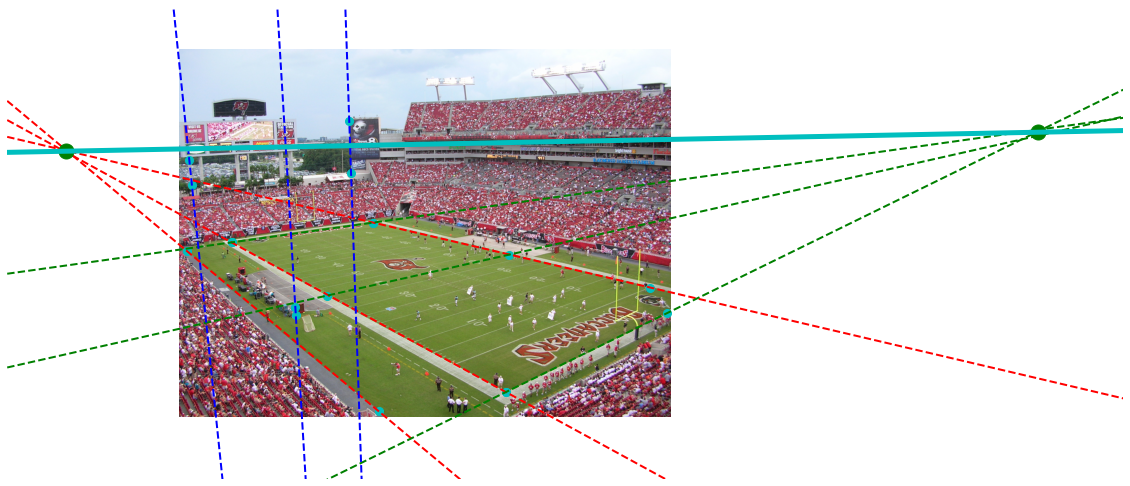

In [15]:
plt.figure(figsize=(20, 40))
plt.imshow(im)
plt.ylim([2000, -200])
xlims = [-800, 4400]
plt.xlim(xlims)
plt.axis('off')

plt.plot(points_x.flatten(), points_y.flatten(), 'co', markersize=8)

for group, color in zip(range(3), ['r', 'g', 'b']):
    c = color + '--'
    for i in range(3):
        draw_line(points_x[:, group, i], 
                  points_y[:, group, i], c=c, xlims=xlims)
        
# draw vanishing points in big green dots
vp_x = vanishing_points
plt.plot(vanishing_points[:, 0], vanishing_points[:, 1], 'go', markersize=15)

# draw the horizon in thick cyan
draw_line(vanishing_points[:2, 0], vanishing_points[:2, 1], 
          c='c', xlims=xlims, linewidth=5)

# Problem 3: Homography

## Problem 3a: Looking at the rectangle 

In [50]:
# Load the 4 corners in pixels and plot the points and use cv2.polylines to draw the polygon

im = np.asarray(Image.open('data/stadium.png'))

corners = []
with open('data/corners.txt','r') as inf:
    for line in inf:
        corners.append(eval(line))  
corners = corners[0] # is now a dictionary

In [53]:
points = np.stack([
    corners['UL'], corners['UR'], corners['LR'], corners['LL']
])
vertices  = points.reshape((-1,1,2)).astype(np.int32)
polygon_image = cv2.polylines(im, [vertices], isClosed=True, 
                   color=(0, 255, 255), thickness=5)

(-0.5, 2287.5, 1711.5, -0.5)

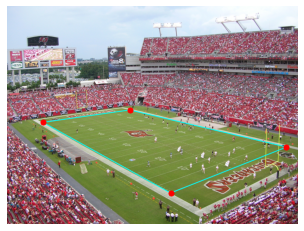

In [55]:
plt.imshow(polygon_image)
plt.plot(points[:, 0], points[:, 1], 'ro', markersize=5)
plt.axis('off')

## Problem 3b: Rectification 

In [61]:
def compute_dist(a, b):
    return np.linalg.norm(a - b)

In [90]:
# Find the homography and rectify the rectangle
# use upperleft as reference
ul, ur, lr, ll = points
aspect_ratio = 1.89

height = round(compute_dist(ul, ll))
width = round(height / aspect_ratio)

ur_dst = np.array([
    ul[0] + width, 
    ul[1]
])

lr_dst = np.array([
    ur_dst[0], 
    ur_dst[1] - height
])

ll_dst = np.array([
    ul[0], 
    ul[1] - height
])

points_dst = np.stack([ul, ur_dst, lr_dst, ll_dst])

In [92]:
points_dst

array([[1286, 1468],
       [1893, 1468],
       [1893,  321],
       [1286,  321]])

In [109]:
# reference: https://learnopencv.com/homography-examples-using-opencv-python-c/
h, status = cv2.findHomography(points, points_dst)
rectified_image = cv2.warpPerspective(polygon_image, h, (2200, 1800))

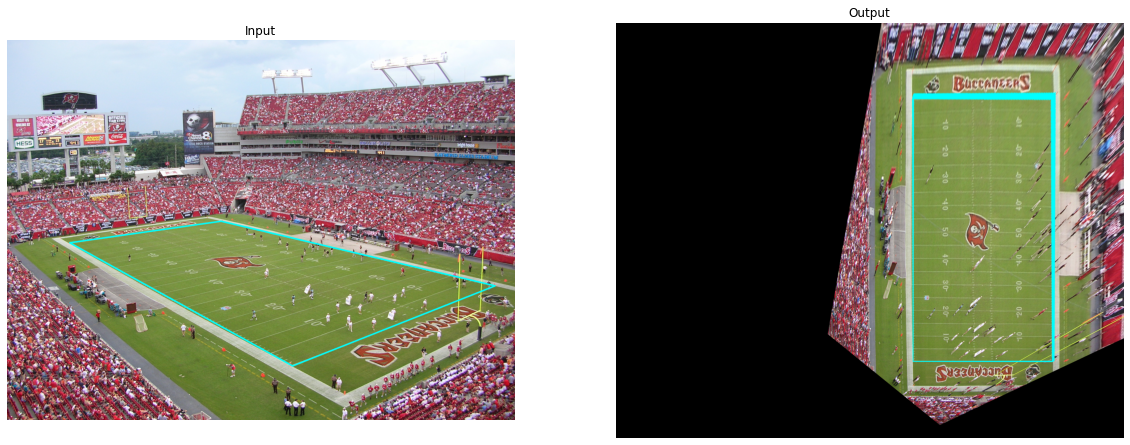

In [110]:
plt.figure(figsize=(20, 40))

plt.axis('off')
plt.subplot(121),plt.imshow(polygon_image),plt.title('Input')
plt.axis('off')
plt.subplot(122),plt.imshow(rectified_image),plt.title('Output')
plt.axis('off')
plt.show()

## Problem 3c: Measuring distances 

In [ ]:
plt.figure(figsize=(20, 40))
plt.imshow(im)

players = []
with open('data/players.txt','r') as inf:
    for line in inf:
        players.append(eval(line))  

players = players[0]

# Plot a few locations on the field, these are points of interest for the next problem
ref1_loc = players['ref1_loc']
ref2_loc = players['ref2_loc']
player_loc = players['player_loc']


In [ ]:

print("The distance between the player and ref1 is: {} yards.".format(result))

# Problem 4

In [ ]:
# interstage measurement from https://spaceflight101.com/spacerockets/falcon-9-ft/
from imageio import imread
plt.figure(figsize=(20, 40))

image = imread('composites.jpg')
plt.imshow(image)

points_dict = []
with open('data/spacex_factory.txt','r') as inf:
    for line in inf:
        points_dict.append(eval(line))  
        
points_dict = points_dict[0]


In [ ]:
from imageio import imread
plt.figure(figsize=(20, 40))

image = imread('composites.jpg')
plt.imshow(image)

# New stuff for this problem
metrology_points = []
with open('data/rocket_metrology.txt','r') as inf:
    for line in inf:
        metrology_points.append(eval(line))  
        
metrology_points = metrology_points[0]

reference_point = metrology_points['reference_point']
top_interstage = metrology_points['top_interstage']
top_nosecone = metrology_points['top_nosecone']
bottom_nosecone = metrology_points['bottom_nosecone']
bottom_interstage = metrology_points['bottom_interstage']


In [ ]:
def cross_ratio(t, b, r, v_z):
    pass

print("The estimated height of the nosecone is: {} meters.".format(H))